# Импорты

In [ ]:
! pip install sentencepiece transformers sacrebleu HeapDict -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.2 MB/s eta 0:00:00


In [ ]:
! wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto

--2023-05-15 17:23:33--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13845 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.52K  --.-KB/s    in 0s      

2023-05-15 17:23:33 (26.5 MB/s) - ‘sentencepiece_model.proto’ saved [13845/13845]



In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
import json
from collections import Counter, defaultdict
from tqdm.auto import tqdm, trange
import random
import re
from copy import deepcopy
import pandas as pd

# Добавляю в модель токены бурятского языка

In [ ]:
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [ ]:
print(tokenizer.vocab_size)

250054


In [ ]:
with open ('bur_all.txt', 'r', encoding='utf-8') as f:
   bur_all = f.readlines()

In [ ]:
bur_all = set(bur_all)
len(bur_all)

203060

In [ ]:
def get_tokens(text, tokenizer, verbose=False):
    toks = tokenizer.tokenize(text)
    words = []
    word = []
    prev_punct = False
    for tok in toks:
        is_punct = tok.lstrip(SPACE) and all(c in PUNCT for c in tok.lstrip(SPACE))
        if tok.startswith(SPACE) or prev_punct != is_punct:
            if word:
                words.append(word)
            word = []
        word.append(tok)
        prev_punct = is_punct
    if word:
        words.append(word)
    if verbose:
        print(words)
    res = words
    # assert tokenizer.decode([tok for t in res for tok in t]) == text
    return res

In [ ]:
PUNCT = '.,-—:)(»«!?–/;„"“…*́№Ёҥ[]”^%+І=і•_􏰀²|}{#‘■>⁠’á<°\§\''
SPACE = '▁'
word_count = Counter()
word2toks = {}
for text in tqdm(bur_all):
    for word_toks in get_tokens(text, tokenizer):
        word = ''.join(word_toks)
        word_count[word] += 1
        word2toks[word] = word_toks
print(len(word_count))

  0%|          | 0/203060 [00:00<?, ?it/s]

465440


In [ ]:
word_count2 = deepcopy(word_count)
word2toks2 = deepcopy(word2toks)

In [ ]:
word_count = deepcopy(word_count2)
word2toks = deepcopy(word2toks2)

In [ ]:
for k, v in word_count.most_common(30):
    if len(word2toks[k]) > 1:
        print(word2toks[k])

['▁гэж', 'э']
['▁h', 'эн']
['▁нэг', 'э']
['▁тэр', 'э']
['▁бай', 'h', 'ан']
['▁л', 'э']
['▁дээр', 'э']
['▁е', 'х', 'э']


In [ ]:
steps = 100_000
min_count = 30  
# default:   0 new tokens, 30 lenght, 0% new tokens
# 100 mindf: 6.6k new tokens, 22 length, 47% new tokens (of sentence length)
# 30 mindf:  20k new tokens, 20 length, 58% new tokens
# 10 mindf: 50K new tokens, 18.5 length, 64% new tokens
extra_vocab = []
extra_counts = []
extra_pairs = []

In [ ]:
pairs_count = Counter()
pair2word = defaultdict(set)
for w, c in tqdm(word_count.items(), total=len(word_count)):
    enc = word2toks[w]
    for pair in zip(enc[:-1], enc[1:]):
        pairs_count[pair] += c
        pair2word[pair].add(w)

  0%|          | 0/465440 [00:00<?, ?it/s]

In [ ]:
from heapdict import heapdict
hd = heapdict()
for w, c in pairs_count.items():
    hd[w] = -c

In [ ]:
def replace_pair(old_tokens, pair, new_token):
    result = []
    prev = old_tokens[0]
    for tok in old_tokens[1:]:
        if (prev, tok) == pair:
            result.append(new_token)
            prev = None
        else:
            if prev is not None:
                result.append(prev)
            prev = tok
    if prev is not None:
        result.append(prev)
    return result

In [ ]:
for _ in trange(steps):
    #pair, c = pairs_count.most_common(1)[0]  # это самая времязатратная операция
    pair, c = hd.peekitem()
    c = -c
    
    if c < min_count:
        break
    new_token = ''.join(pair) # instead of BERT-like pair[0] + pair[1][2:]
    extra_vocab.append(pair)
    extra_counts.append(c)
    extra_pairs.append(pair)
    
    # update the vocabulary
    #new_id = len(id2ids)
    #tok2id[new_token] = new_id
    #id2ids.append(id2ids[tok2id[pair[0]]] + id2ids[tok2id[pair[1]]]) 
    
    # calculate the delta for the heap
    delta = Counter()
    for word in list(pair2word[pair]):
        # calculate old and new ways to tokenize the word
        old_toks = word2toks[word]
        # new_toks = " ".join(old_toks).replace(' '.join(pair), new_token).split(" ")
        new_toks = replace_pair(old_toks, pair, new_token)
        word2toks[word] = new_toks
        wc = word_count[word]
        # update the index concerning the tokens of the word
        for old_pair in zip(old_toks[:-1], old_toks[1:]):
            #pairs_count[old_pair] -= wc
            delta[old_pair] -= wc
            if word in pair2word[old_pair]:
                pair2word[old_pair].remove(word)
        for new_pair in zip(new_toks[:-1], new_toks[1:]):
            # pairs_count[new_pair] += wc
            delta[new_pair] += wc
            pair2word[new_pair].add(word)
    # update the heap
    for a_pair, a_delta in delta.items():
        if a_delta == 0:
            continue
        if a_pair not in hd:
            hd[a_pair] = 0
        hd[a_pair] -= a_delta

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
len(extra_pairs)

21818

In [ ]:
extra_pairs[:10]

[('h', 'ан'),
 ('▁гэж', 'э'),
 ('h', 'эн'),
 ('х', 'э'),
 ('h', 'а'),
 ('б', 'э'),
 ('шь', 'е'),
 ('▁я', 'ба'),
 ('я', 'а'),
 ('h', 'аа')]

In [ ]:
tokenizer.save_pretrained('old_tokenizer')

('old_tokenizer/tokenizer_config.json',
 'old_tokenizer/special_tokens_map.json',
 'old_tokenizer/sentencepiece.bpe.model',
 'old_tokenizer/added_tokens.json')

In [ ]:
# with open('extra_pairs.json', 'w', encoding='utf-8') as f:
#   json.dump(extra_pairs, f)

In [ ]:
# with open('extra_vocab.json', 'w', encoding='utf-8') as f:
#   json.dump(extra_vocab, f)

In [ ]:
# with open('extra_vocab.json', 'r', encoding='utf-8') as f:
#   extra_vocab = json.load(f)

In [ ]:
# with open('extra_pairs.json', 'r', encoding='utf-8') as f:
#   extra_pairs = json.load(f)

In [ ]:
!pip install --upgrade "protobuf<=3.20.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery 3.9.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery-storage 2.19.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4

In [ ]:
import sentencepiece_model_pb2 as model
m = model.ModelProto()
m.ParseFromString(open("old_tokenizer/sentencepiece.bpe.model", "rb").read())

5069051

In [ ]:
scores = [p.score for p in m.pieces]
min_score = min(scores)
epsilon = 1e-4

In [ ]:
for i, pair in enumerate(extra_vocab):
    new_token = model.ModelProto().SentencePiece()
    new_token.piece = ''.join(pair)
    new_token.score = min_score - epsilon * (i+1)
    m.pieces.append(new_token)

In [ ]:
with open("old_tokenizer/sentencepiece.bpe.model", 'wb') as f:
    f.write(m.SerializeToString())

In [ ]:
tokenizer =  MBart50Tokenizer.from_pretrained(
    "old_tokenizer/") 

In [ ]:
new_tokenizer = MBart50Tokenizer.from_pretrained(
    "old_tokenizer/", 
    additional_special_tokens = tokenizer.additional_special_tokens
)

In [ ]:
new_tokenizer.vocab_size

271872

7893 новых токенов

In [ ]:
from transformers.models.mbart50.tokenization_mbart50 import FAIRSEQ_LANGUAGE_CODES

In [ ]:
self = new_tokenizer

In [ ]:
self.lang_code_to_id = {
    code: self.sp_model_size + i + self.fairseq_offset for i, code in enumerate(FAIRSEQ_LANGUAGE_CODES + ['bxr_XX'])
}
self.id_to_lang_code = {v: k for k, v in self.lang_code_to_id.items()}
self.fairseq_tokens_to_ids["<mask>"] = len(self.sp_model) + len(self.lang_code_to_id) + self.fairseq_offset

self.fairseq_tokens_to_ids.update(self.lang_code_to_id)
self.fairseq_ids_to_tokens = {v: k for k, v in self.fairseq_tokens_to_ids.items()}

In [ ]:
new_tokenizer.additional_special_tokens.append('bxr_XX')

In [ ]:
# +1 токен для обозначения языка
new_tokenizer.vocab_size

271873

In [ ]:
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [ ]:
print(tokenizer.tokenize(text))
print(new_tokenizer.tokenize(text))

['▁Ен', 'дон', ',', '▁ши', ',', '▁х', 'яла', 'йл', '-', '▁га', 'жа', ',', '▁энэ', '▁Нор', 'жо', 'мо', '▁у', 'б', 'сан', 'са', 'тай', 'м', '▁на', 'ана', 'тай', '▁са', 'ана', 'тай', 'хан', '▁я', 'ба', 'h', 'ан', '▁бэ', 'з', 'эт', ',', '▁мэд', 'энэ', 'б', ',', '—', '▁', 'гэн', '▁тэр', 'э', '▁хор', 'о', 'гүй', 'хэн', 'өөр', '▁эне', 'э', '-', '▁с', 'эг', 'ээ', 'б', 'э', '.']
['▁Ендон', ',', '▁ши', ',', '▁х', 'яла', 'йл', '-', '▁гажа', ',', '▁энэ', '▁Норжомо', '▁убсан', 'са', 'тай', 'м', '▁на', 'ана', 'тай', '▁са', 'ана', 'тайхан', '▁ябаhан', '▁бэзэт', ',', '▁мэдэнэб', ',', '—', '▁', 'гэн', '▁тэрэ', '▁хор', 'о', 'гүйхэнөөр', '▁энеэ', '-', '▁сэгээ', 'бэ', '.']


In [ ]:
random.seed(1)
sample = random.sample(bur_all, 10000)

<ipython-input-40-aaaef8a53f32>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(bur_all, 10000)


In [ ]:
# по 10к предложений статистика длины токенов
pd.DataFrame({
    'old': [len(tokenizer.tokenize(text)) for text in sample], 
    'new': [len(new_tokenizer.tokenize(text)) for text in sample]
}).describe()

,old,new
count,10000.000000,10000.000000
mean,52.313700,31.575900
std,70.951928,43.196364
min,3.000000,2.000000
25%,20.000000,12.000000
50%,34.000000,21.000000
75%,60.000000,36.000000
max,3601.000000,2183.000000


## Calculating tokens alignment

In [ ]:
with open('train.json', 'r', encoding='utf-8') as f:
    all_pairs = json.load(f)

In [ ]:
'длина параллельного текста (предложения и слова) ', len(all_pairs)

('длина параллельного текста (предложения и слова) ', 36437)

In [ ]:
from collections import defaultdict, Counter
token_priors = Counter()
token_to_others = defaultdict(Counter)

In [ ]:
for bur, ru in tqdm(all_pairs):
    bur_toks = new_tokenizer.convert_tokens_to_ids(new_tokenizer.tokenize(bur))
    ru_toks = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ru))
    token_priors.update(ru_toks)
    for bur_tok in bur_toks:
        token_to_others[bur_tok].update(ru_toks)

  0%|          | 0/36437 [00:00<?, ?it/s]

In [ ]:
import numpy as np

def get_ru_toks(bxr_tok):
    ru_toks = []
    ru_weights = []
    for t, w in token_to_others[bxr_tok].items():
        ru_toks.append(t)
        ru_weights.append(w**2 / token_priors[t])
    ru_weights = np.array(ru_weights)
    ru_weights = ru_weights / (sum(ru_weights) + 1e-4)
    return ru_weights, ru_toks

In [ ]:
bur, ru = random.choice(all_pairs)
bur, ru

('хооллуулха', 'кормить')

In [ ]:
print(new_tokenizer.convert_tokens_to_ids(new_tokenizer.tokenize(bur)))

[77543, 256997]


In [ ]:
bur_token = 37976

In [ ]:
sorted(zip(*get_ru_toks(bur_token)), reverse=True)[:5]

[(0.5936369129097556, 37976),
 (0.39575794193983704, 222149),
 (0.0060885837221513394, 42315),
 (0.002314373929472731, 17512),
 (0.0021626117045892737, 49517)]

In [ ]:
tokenizer.convert_ids_to_tokens([37976, 222149, 42315,  17512, 49517])

['▁демократ', '▁демократия', 'изация', 'изм', 'ический']

## Updating the model embeddings

In [ ]:
len(new_tokenizer)

271873

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [ ]:
model.model.shared

Embedding(250054, 1024, padding_idx=1)

In [ ]:
# изменяем размер токенов
model.resize_token_embeddings(len(new_tokenizer))

Embedding(271873, 1024)

In [ ]:
n_extra = len(extra_vocab)
print(n_extra)
old_vocab_size = len(tokenizer.sp_model) + 1

21818


In [ ]:
old_vocab_size

250001

In [ ]:
# токены, кодирующие язык "переместили" в конец по айди

for old_token_id in range(old_vocab_size, len(tokenizer)):
    old_token = tokenizer.convert_ids_to_tokens(old_token_id)
    new_token_id = new_tokenizer.convert_tokens_to_ids(old_token)
    
    print(old_token_id, old_token, new_token_id)
    # model.model.shared.weight.data[i + n_extra] = model.model.shared.weight.data[i]
    model.model.shared.weight.data[new_token_id] = model.model.shared.weight.data[old_token_id]

250001 ar_AR 271819
250002 cs_CZ 271820
250003 de_DE 271821
250004 en_XX 271822
250005 es_XX 271823
250006 et_EE 271824
250007 fi_FI 271825
250008 fr_XX 271826
250009 gu_IN 271827
250010 hi_IN 271828
250011 it_IT 271829
250012 ja_XX 271830
250013 kk_KZ 271831
250014 ko_KR 271832
250015 lt_LT 271833
250016 lv_LV 271834
250017 my_MM 271835
250018 ne_NP 271836
250019 nl_XX 271837
250020 ro_RO 271838
250021 ru_RU 271839
250022 si_LK 271840
250023 tr_TR 271841
250024 vi_VN 271842
250025 zh_CN 271843
250026 af_ZA 271844
250027 az_AZ 271845
250028 bn_IN 271846
250029 fa_IR 271847
250030 he_IL 271848
250031 hr_HR 271849
250032 id_ID 271850
250033 ka_GE 271851
250034 km_KH 271852
250035 mk_MK 271853
250036 ml_IN 271854
250037 mn_MN 271855
250038 mr_IN 271856
250039 pl_PL 271857
250040 ps_AF 271858
250041 pt_XX 271859
250042 sv_SE 271860
250043 sw_KE 271861
250044 ta_IN 271862
250045 te_IN 271863
250046 th_TH 271864
250047 tl_XX 271865
250048 uk_UA 271866
250049 ur_PK 271867
250050 xh_ZA 271868


~ 50 токенов для языков

Because we have added one more language, its id must be computed separately, e.g. as an average of related languages

In [ ]:
model.model.shared.weight.data[new_tokenizer.convert_tokens_to_ids('bxr_XX')] = (
    model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('mn_MN')] * 0.45
    + model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('ru_RU')] * 0.45
)

Compute embeddings for newly added tokens

In [ ]:
for i in trange(n_extra):
    bxr_tok = i + old_vocab_size
    ru_weights, ru_toks = get_ru_toks(bxr_tok)
    if len(ru_toks) > 0:
        new_embedding = (model.model.shared.weight.data[ru_toks].T * ru_weights).sum(1)
        model.model.shared.weight.data[bxr_tok] = new_embedding

  0%|          | 0/21818 [00:00<?, ?it/s]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# new_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v0'

In [ ]:
# model.save_pretrained(new_model_path)
# new_tokenizer.save_pretrained(new_model_path)

In [ ]:
# !ls -alsh $new_model_path

# Обучение модели на машинный перевод

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install transformers sentencepiece sacrebleu -q

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random
import torch
from transformers.optimization import Adafactor
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

In [ ]:
# base_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v0'

In [ ]:
# tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)
# model = MBartForConditionalGeneration.from_pretrained(base_model_path)

tokenizer = new_tokenizer
# model = model

In [ ]:
old_len = len(tokenizer)
old_len

271873

In [ ]:
tokenizer.lang_code_to_id['bxr_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'bxr_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'bxr_XX' not in tokenizer.additional_special_tokens:
    tokenizer.additional_special_tokens.append('bxr_XX')

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
model.cuda();

## First, update just the new embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8  
report_steps = 500 
epochs = 4
losses = []

In [ ]:
tokenizer.src_lang = "ru_RU"
tokenizer.tgt_lang = "bxr_XX"

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/4554 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


step 0 loss 21.690710067749023
step 500 loss 12.98296265888214
step 1000 loss 3.9088333790302277
step 1500 loss 3.037629452228546
step 2000 loss 2.7774633605480195
step 2500 loss 2.6704323855638505
step 3000 loss 2.507295617580414
step 3500 loss 2.462485101044178
step 4000 loss 2.3109037311673166
step 4500 loss 2.3282634855508806
EPOCH 1


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 2.323996705889702
step 500 loss 2.173558047473431
step 1000 loss 2.0915973439216615
step 1500 loss 2.035033663213253
step 2000 loss 1.9795053061246872
step 2500 loss 1.9560563537478446
step 3000 loss 1.9070602214932442
step 3500 loss 1.895083561897278
step 4000 loss 1.8238713956475259
step 4500 loss 1.803546823620796
EPOCH 2


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.8084538477659224
step 500 loss 1.7329956040382386
step 1000 loss 1.7161209713220595
step 1500 loss 1.7168946150541307
step 2000 loss 1.6951209539175034
step 2500 loss 1.6786746479272843
step 3000 loss 1.6861043221950531
step 3500 loss 1.6267967456579209
step 4000 loss 1.635263086438179
step 4500 loss 1.6136121502518654
EPOCH 3


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.6175390809178352
step 500 loss 1.5515581198334694
step 1000 loss 1.5272878391742706
step 1500 loss 1.531065664410591
step 2000 loss 1.5398667674660682
step 2500 loss 1.495337900429964
step 3000 loss 1.4820648760795594
step 3500 loss 1.4894719809889794
step 4000 loss 1.4584891943633556
step 4500 loss 1.4471651047468186


In [ ]:
# save_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v11'

In [ ]:
# model.save_pretrained(save_model_path)
# tokenizer.save_pretrained(save_model_path)

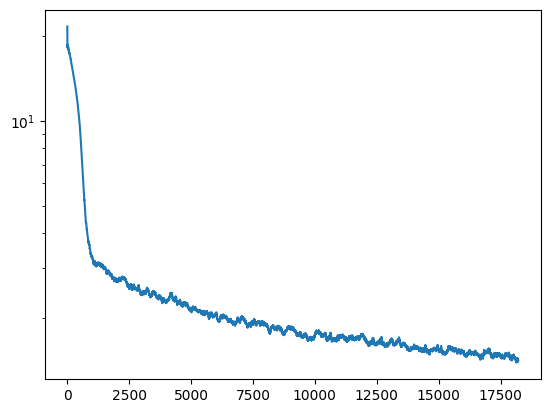

In [ ]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

# Now update the whole model, with embeddings and transformer layers.

In [ ]:
# save_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v11'

In [ ]:
# model = MBartForConditionalGeneration.from_pretrained(save_model_path)
# tokenizer = MBart50Tokenizer.from_pretrained(save_model_path)

In [ ]:
model.cuda();

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8
report_steps = 500 
epochs = 3
losses = []


Optimizing all parameters takes x2 longer than just embeddings: about 1h per epoch.

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/4554 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


step 0 loss 1.0483763217926025
step 500 loss 1.3862910569906235
step 1000 loss 1.3974454475939273
step 1500 loss 1.348259232610464
step 2000 loss 1.3197441850304603
step 2500 loss 1.3183580011129379
step 3000 loss 1.3290887697041034
step 3500 loss 1.3316714582443236
step 4000 loss 1.3329032189249992
step 4500 loss 1.301239540398121
EPOCH 1


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.292017736494541
step 500 loss 1.3100648872852325
step 1000 loss 1.2830370954871178
step 1500 loss 1.280520920932293
step 2000 loss 1.276952338039875
step 2500 loss 1.2734798711836337
step 3000 loss 1.2535767722725868
step 3500 loss 1.2455858615636826
step 4000 loss 1.2591164926290512
step 4500 loss 1.2566029347777368
EPOCH 2


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.2495812956094743
step 500 loss 1.278079561293125
step 1000 loss 1.2284795314967631
step 1500 loss 1.2092169977426528
step 2000 loss 1.249508705317974
step 2500 loss 1.2329348028600216
step 3000 loss 1.2069567253887654
step 3500 loss 1.2452059502601625
step 4000 loss 1.2202672185897827
step 4500 loss 1.191116583198309


In [ ]:
cleanup()
model.train()
epochs = 1
for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.179519863575697
step 500 loss 1.215529891014099
step 1000 loss 1.2243293307721614
step 1500 loss 1.2147553361058234
step 2000 loss 1.1994441390037536
step 2500 loss 1.2404443114697934
step 3000 loss 1.1745946739912032
step 3500 loss 1.2110921602547169
step 4000 loss 1.1848180911839008
step 4500 loss 1.2043530771136284


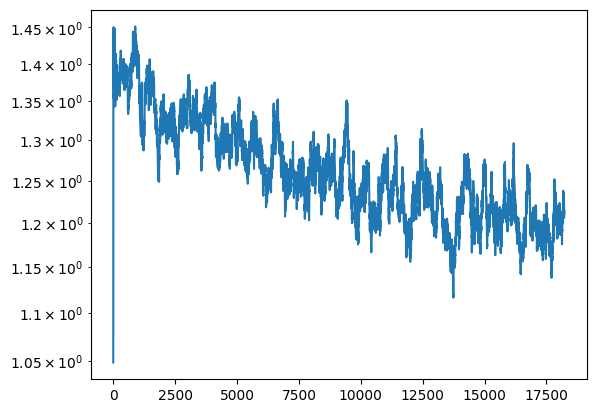

In [ ]:
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

In [ ]:
model.eval()

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(271873, 1024)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(271873, 1024)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementw

In [ ]:
bxr, ru = random.choice(all_pairs)
bxr, ru

('эхирлэхэ', 'рождать близнецов')

In [ ]:
def translate(text, src='ru_RU', trg='bxr_XX', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

translate(bxr)

'эхирлэхэ'

In [ ]:
import os
os.makedirs("mbart-large-50-bxr-v13")
model.save_pretrained("mbart-large-50-bxr-v13")

In [ ]:
tokenizer.save_pretrained('mbart-large-50-bxr-v13')

('mbart-large-50-bxr-v13/tokenizer_config.json',
 'mbart-large-50-bxr-v13/special_tokens_map.json',
 'mbart-large-50-bxr-v13/sentencepiece.bpe.model',
 'mbart-large-50-bxr-v13/added_tokens.json')

In [ ]:
with open('test.json', 'r') as f:
    test = json.load(f)

In [ ]:
target = [ru for bxr, ru in test]
translated = [translate(ru) for bxr, ru in tqdm(test)]

  0%|          | 0/1823 [00:00<?, ?it/s]

In [ ]:
from sacrebleu import BLEU, CHRF
chrf = CHRF()
bleu = BLEU()

In [ ]:
print('chrF: ', chrf.corpus_score(translated, target).score,
      'BLEU: ', bleu.corpus_score(translated, target).score)

chrF:  4.999999999999999 BLEU:  0.7589531973576789


In [ ]:
for i in range(len(test)):
  if i%50==0:
        print(test[i][1])
        print('эталон: ', test[i][0])
        print('перевод: ', translated[i])
        print()

Ибо вы, люди разумные, охотно терпите неразумных:
эталон:  Таанад өөhэдөө ехэл сэсэн ухаантай, тиин тэнэг үбэштэй зондо ехэл тэсэбэритэй байдаг ха юмта!
перевод:  Аха дүүнэрни, таанад тэнэг хүнүүдэй тэсэбэритэй байдагт.

Тогда он закричал: Иисус, Сын Давидов! помилуй меня.
эталон:  Тиихэдэнь hохор хүн: «Давидай үри hадаhан Иисус, намайе үршөөжэ хайрлыш!» – гэжэ хашхарба. 
перевод:  «Иисус, Давидай үри hадаhан! намайе хүлисээрэй», – гэжэ Иисус хашхаралдаба.

Истинно говорю вам: не прейдет род сей, как все сие будет;
эталон:  Мүнөө ажамидаржа байhан хүнүүдэй бултанайнь үхэжэ үрдеэгүй байхада минии таанадта хэлэhэн бүхэн тохёолдохо гэжэ таанадта баталан хэлэнэб.
перевод:  Таанадта үнэниие хэлэнэб:„Энэ дэлхэйн арад зоной бүхы юумэнтэй хамта байхагүй.

И Я даю им жизнь вечную, и не погибнут вовек; и никто не похитит их из руки Моей.
эталон:  Би тэдэндэ мүнхэ наhа үгэнэб, тэдэ хэзээшье хосорхогүй, тэдэниие намhаа хэншье буляажа абахагүй.
перевод:  Тиимэhээ би тэдэндээ мүнхын амидыруулаа, тэд

In [ ]:
for i in range(len(test)):
  translated[i]

In [ ]:
with open('translated_ru_bxr.txt', 'w', encoding='utf-8') as f:
  for i in translated:
    f.write(f'{i}\n')

# Evaluate